In [1]:
!pip uninstall mxnet -y

In [ ]:
!pip uninstall mxnet-cu112 -y

In [1]:
%%writefile requirements.txt

ipywidgets
matplotlib
ujson
pathlib
#mxnet
mxnet-cu112
gluonts

Overwriting requirements.txt


In [ ]:
%pip install -r requirements.txt

In [3]:
import IPython

## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import mxnet

In [3]:
!nvidia-smi

Thu Mar  3 13:00:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
from pathlib import Path

In [5]:
from mxnet import gpu

In [6]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import NegativeBinomialOutput
from gluonts.evaluation import make_evaluation_predictions

## Loading Data

In [7]:
daily_data_dir = Path('./data')

In [8]:
nbcu_comp_train = pd.read_csv(daily_data_dir/"nbcu_train_validation.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_train.columns = ['site_id', 'inventory']
nbcu_comp_test = pd.read_csv(daily_data_dir/"nbcu_blindtest_1.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_test.columns = ['site_id', 'inventory']
event_ts = pd.read_csv(daily_data_dir/"event_ts_2021-12-05.csv", index_col=1, parse_dates=True, header=None)
event_ts.columns = ['site_id', 'nfl', 'so', 'wo']

In [9]:
event_ts = event_ts[['nfl', 'so', 'wo']][2618:-127]
event_ts

nfl  so  wo
1                      
2019-01-01    0   0   0
2019-01-02    0   0   0
2019-01-03    0   0   0
2019-01-04    0   0   0
2019-01-05    0   0   0
...         ...  ..  ..
2021-07-27    0   1   0
2021-07-28    0   1   0
2021-07-29    0   1   0
2021-07-30    0   1   0
2021-07-31    0   1   0

[943 rows x 3 columns]

In [10]:
usable_sites = pd.read_csv(daily_data_dir/"non_zero_2021-05-31.csv", header=None)[0].to_list()

In [11]:
print('Train:', nbcu_comp_train.shape)
print('Test:', nbcu_comp_test.shape)
print('Event:', event_ts.shape)

Train: (1554966, 2)
Test: (41236, 2)
Event: (943, 3)


In [12]:
merged_df = pd.concat(
    [nbcu_comp_train, nbcu_comp_test], axis=0
)

In [13]:
selected_df = merged_df.loc[merged_df['site_id'].isin(usable_sites)]
selected_df

site_id  inventory
1                             
2019-01-01   206024     6789.0
2019-01-01   208993     2561.0
2019-01-01   235406    12935.0
2019-01-01   235407     4483.0
2019-01-01   416811   506297.0
...             ...        ...
2021-07-31   921103     5421.0
2021-07-31   921211   122600.0
2021-07-31   927421        0.0
2021-07-31   929242    57518.0
2021-07-31   945745        0.0

[476215 rows x 2 columns]

In [14]:
ds_meta = {
    'num_series': selected_df['site_id'].unique().shape[0],
    'num_steps': nbcu_comp_train.index.unique().shape[0],
    'prediction_length': nbcu_comp_test.index.unique().shape[0],
    'validation_length': nbcu_comp_test.index.unique().shape[0]*2,
    'freq': '1D',
    'start': [
        nbcu_comp_train.index[0]
        for _ in range(1)
    ]
}

In [15]:
ds_meta

{'num_series': 505,
 'num_steps': 882,
 'prediction_length': 61,
 'validation_length': 122,
 'freq': '1D',
 'start': [Timestamp('2019-01-01 00:00:00')]}

## Plot and data-set func

In [16]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150, prediction_intervals = (10.0, 90.0)):
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [1]:
def network_dataset(data_df:pd, event, freq='D', valid_length=0, test_length=0):
    # data_df: base dataset from by network inventories
    data_df = data_df.pivot_table(index=data_df.index, columns=['site_id']).fillna(0)
    
    #remove this line after testing
    #data_df = data_df[1:2]
    
    num_series, num_steps = data_df.shape
    print(num_series, num_steps, data_df.columns[0][1]) 
    
    train_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-(valid_length+test_length)],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-(valid_length+test_length)].transpose() if len(event) > 0  else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    valid_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-test_length],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-test_length].transpose() if len(event) > 0  else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )    
    test_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r,
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event.transpose() if len(event) > 0  else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    
    return train_ds, valid_ds, test_ds #target, feat_dynamic_real, feat_static_cat

NameError: name 'pd' is not defined

## Data set prep and review

In [18]:
train_ds, valid_ds, test_ds = network_dataset(
    selected_df, 
    [], #event_ts[['nfl', 'so', 'wo']].values,
    freq=ds_meta['freq'],
    valid_length=0, #ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

505 943 2019-01-01 00:00:00


In [19]:
train_entry = next(iter(train_ds))
train_entry.keys()
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['item_id', 'target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

## Training

100%|██████████| 90/90 [00:16<00:00,  5.46it/s, epoch=40/40, avg_epoch_loss=6.68]


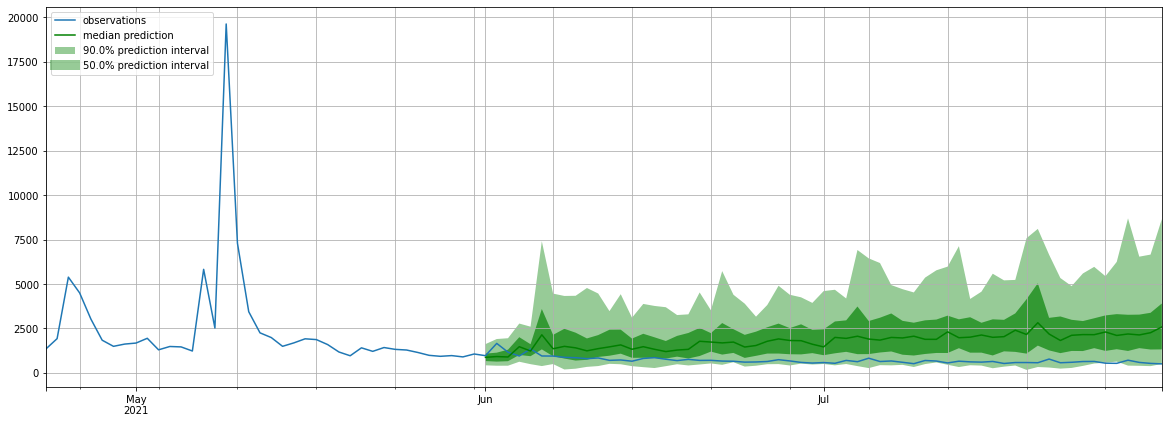

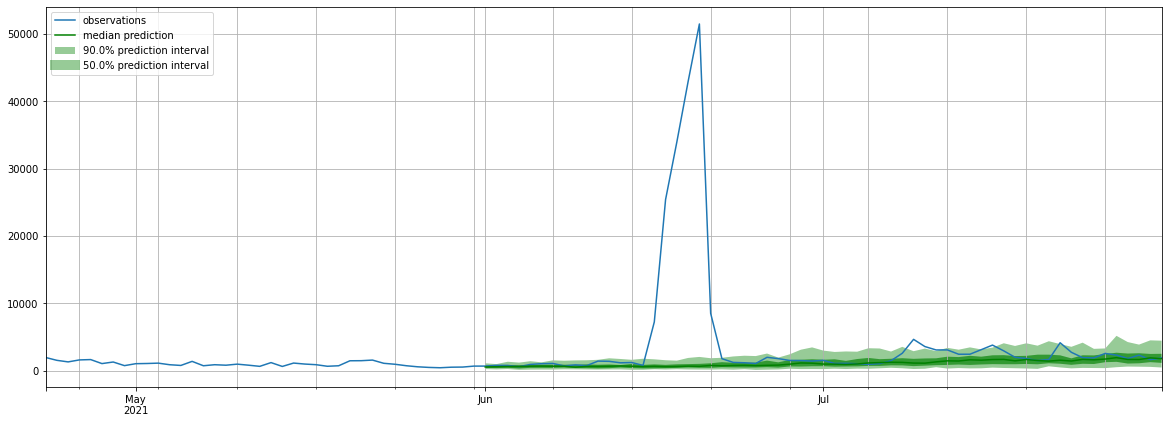

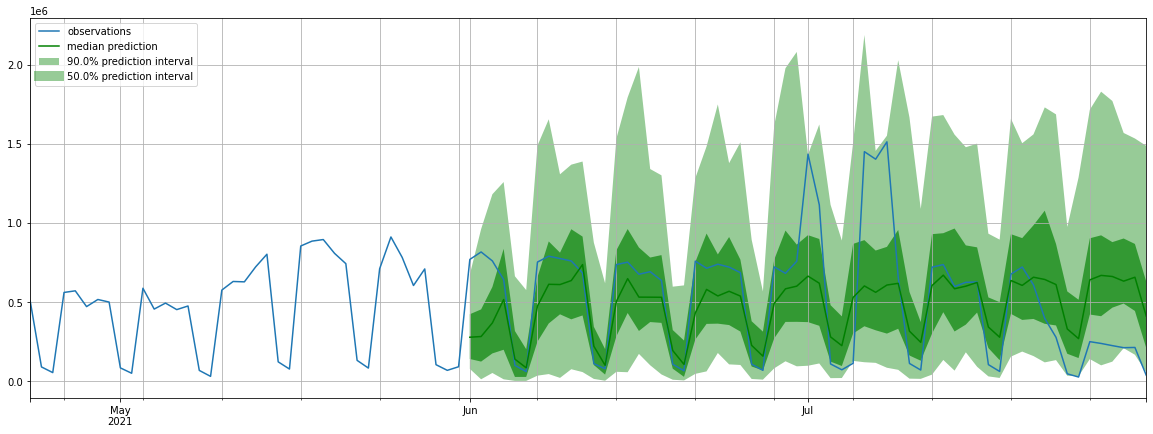

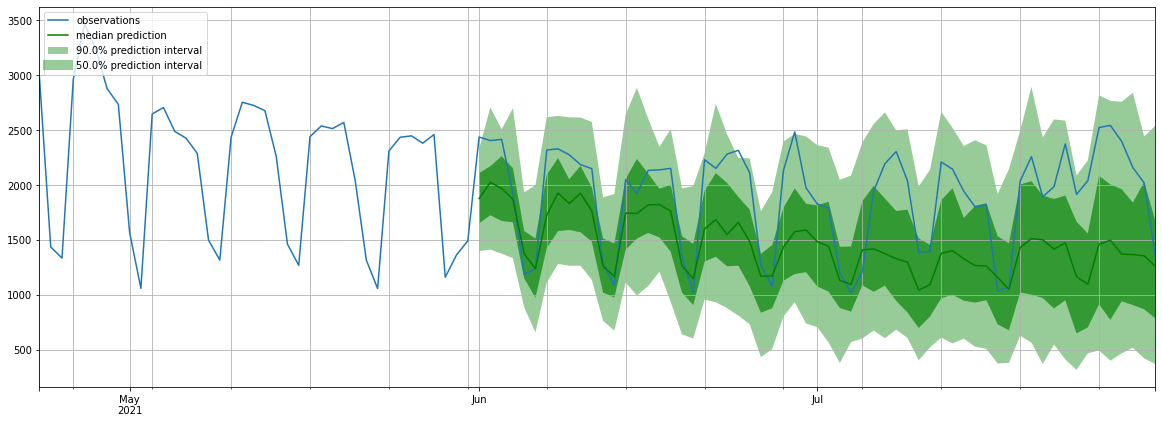

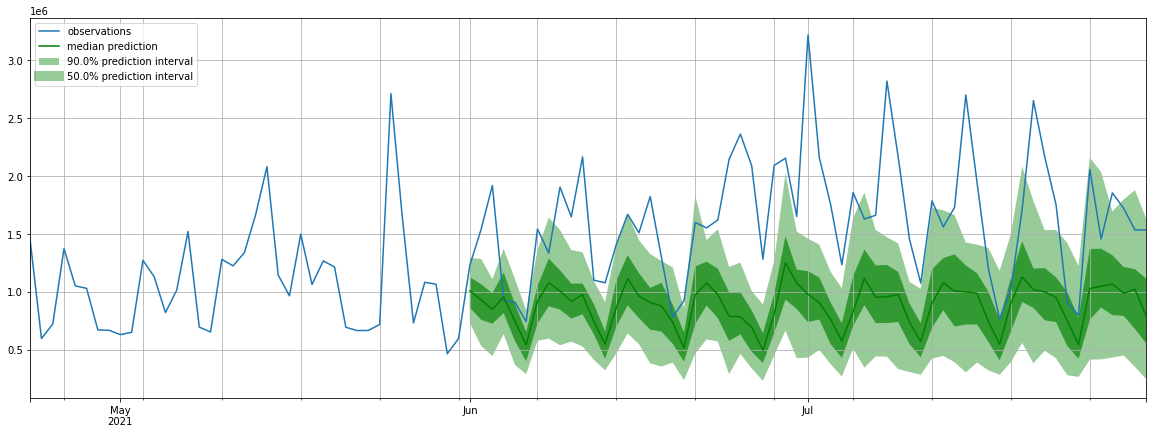

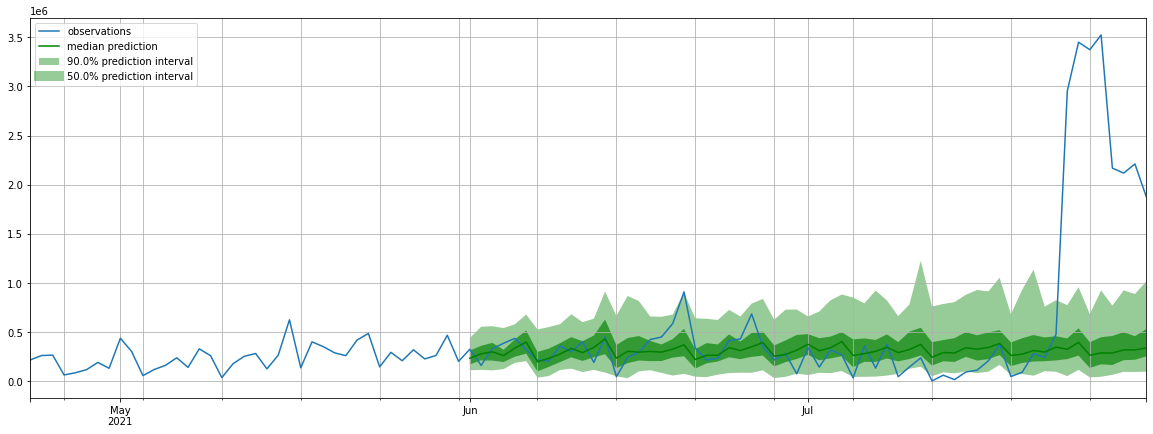

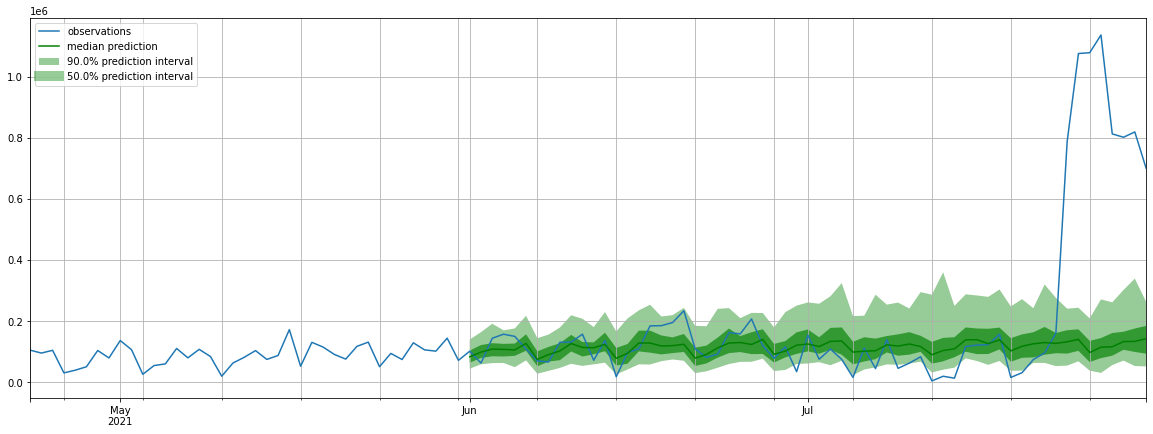

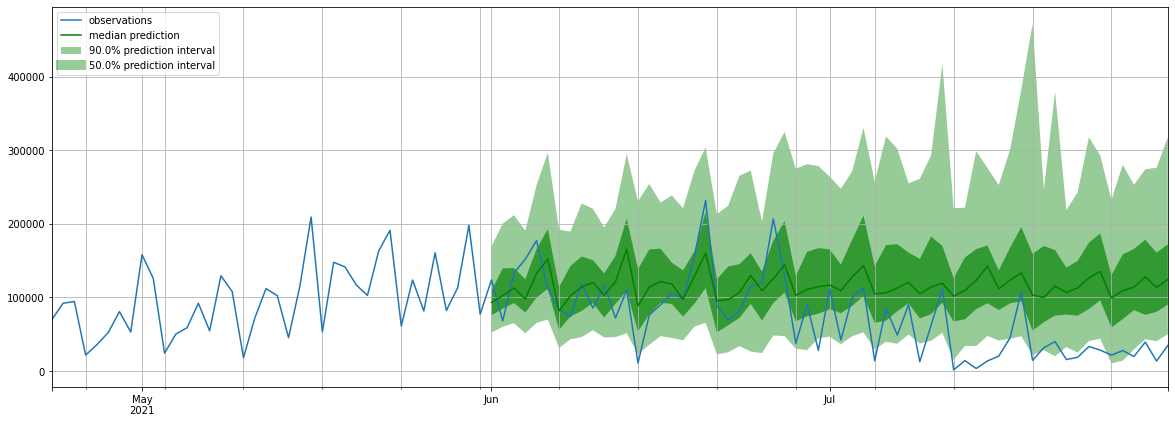

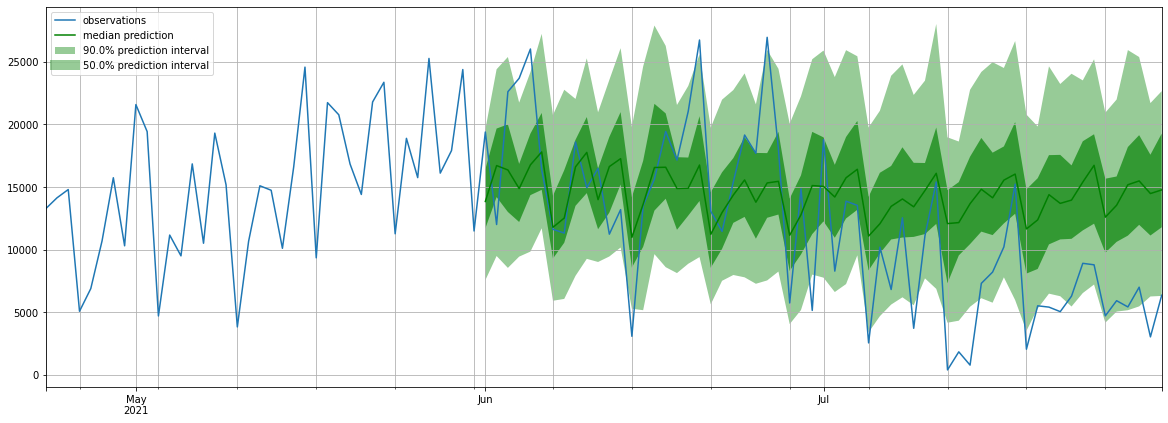

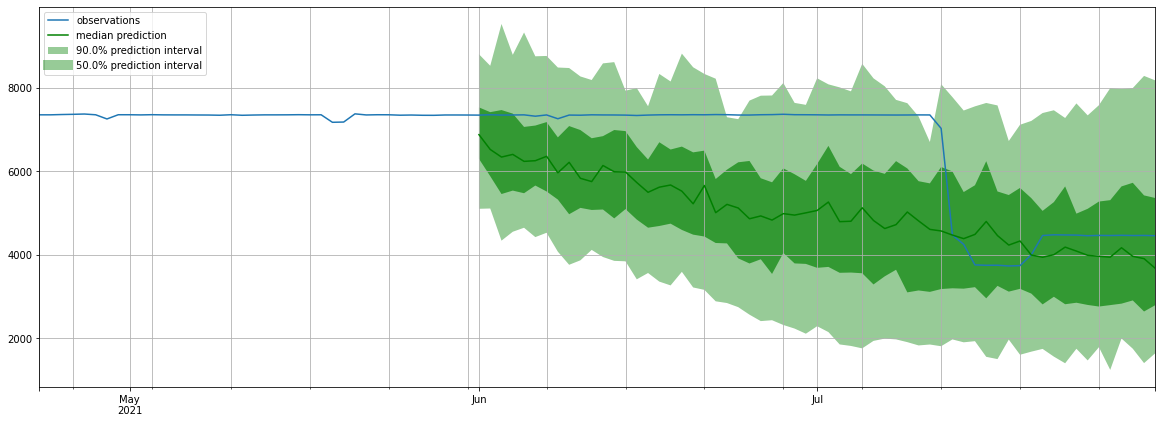

100%|██████████| 90/90 [00:16<00:00,  5.42it/s, epoch=40/40, avg_epoch_loss=7.06]


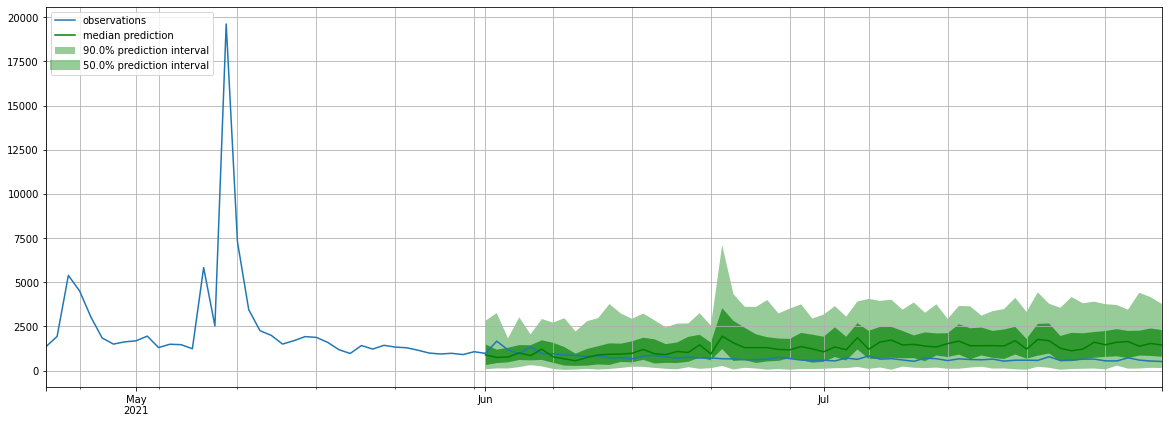

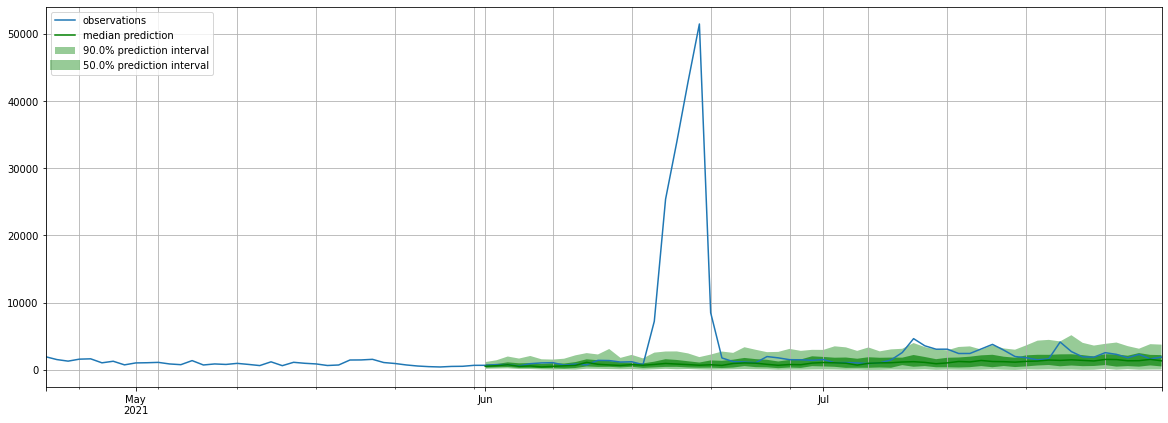

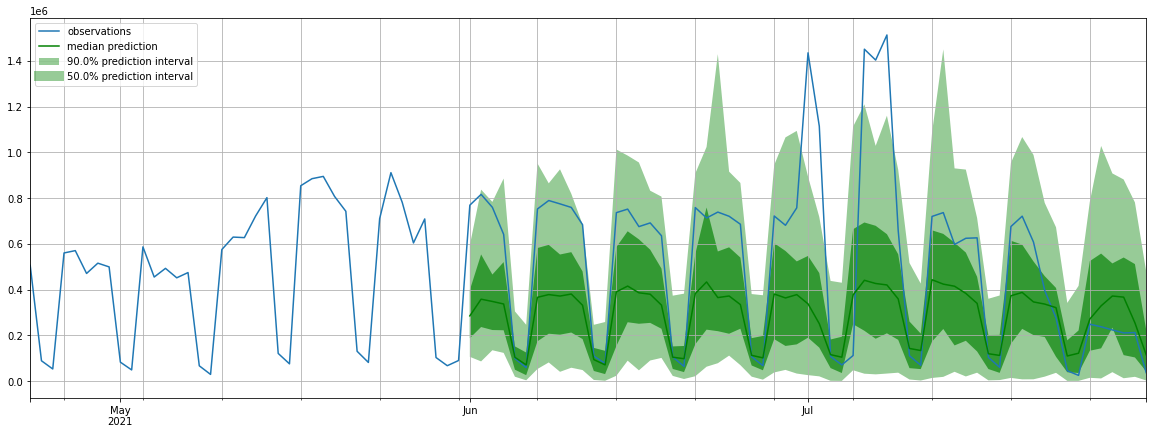

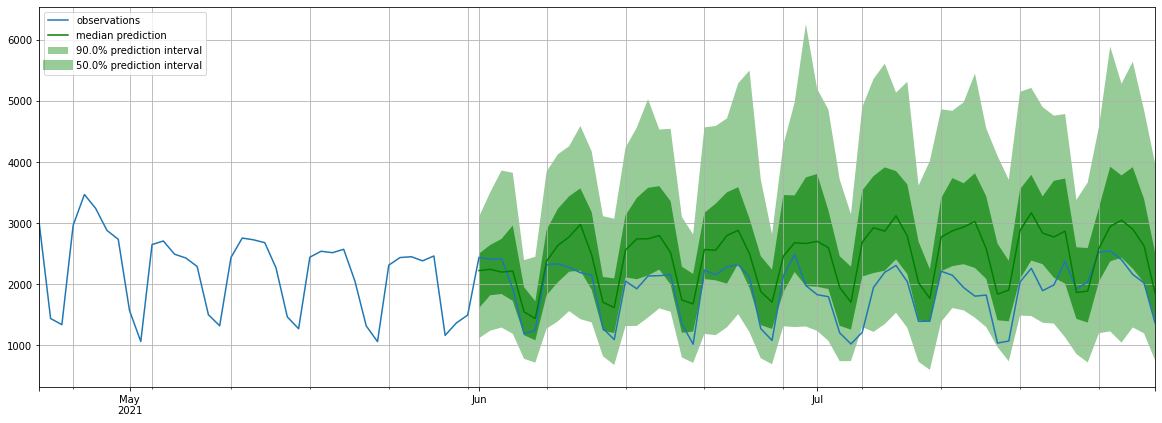

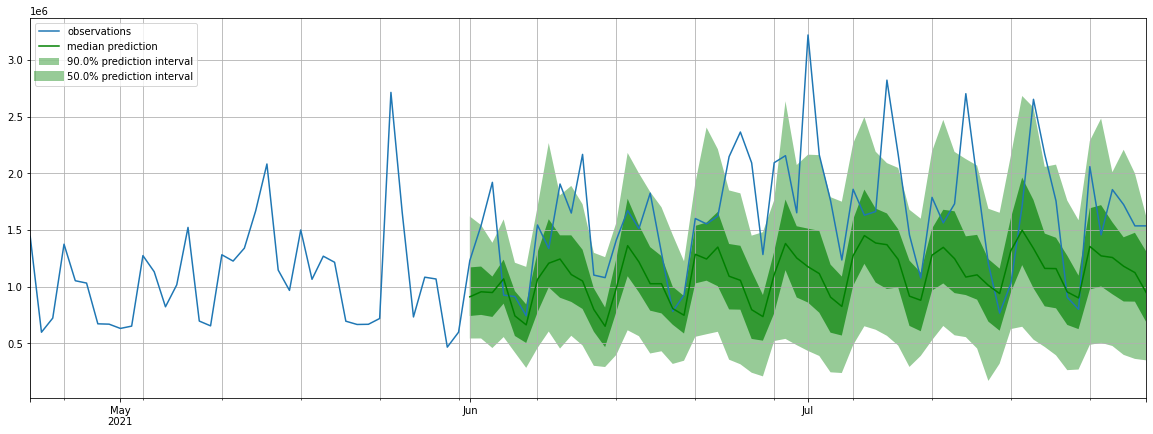

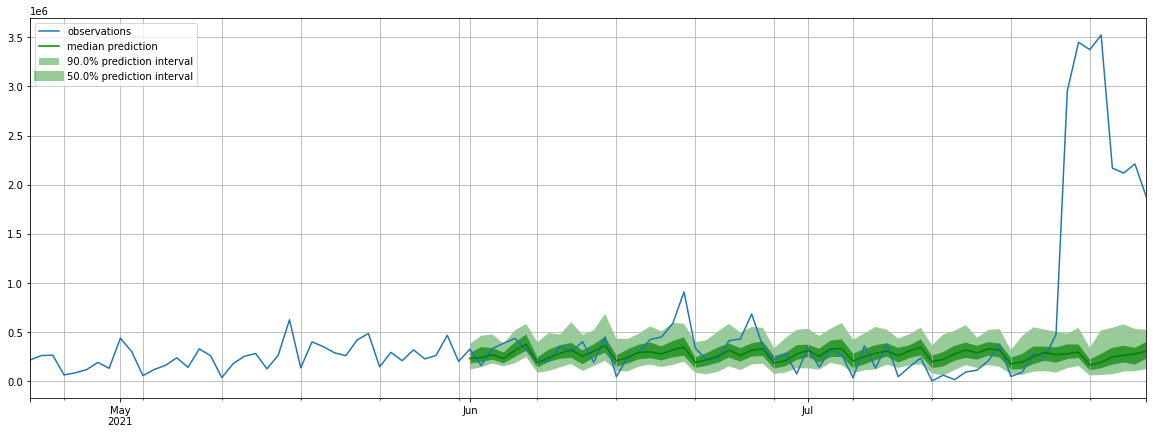

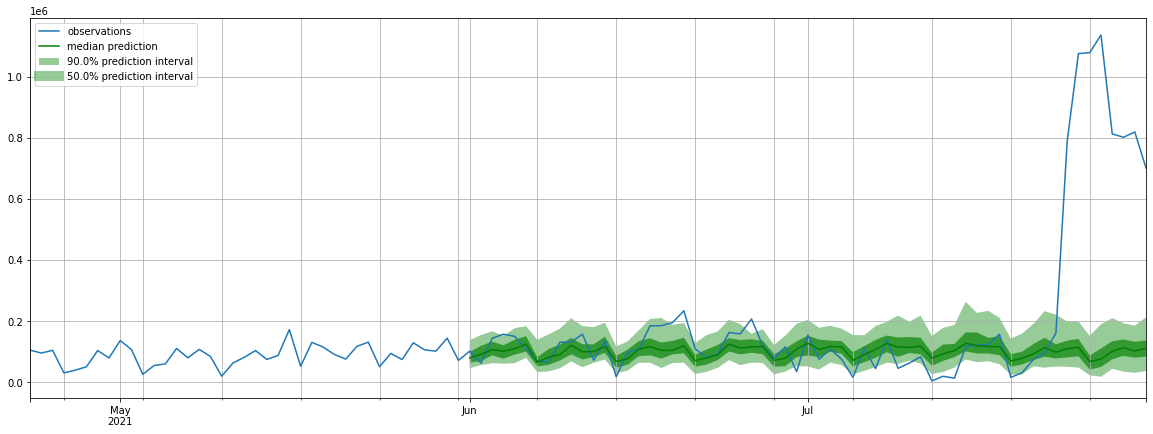

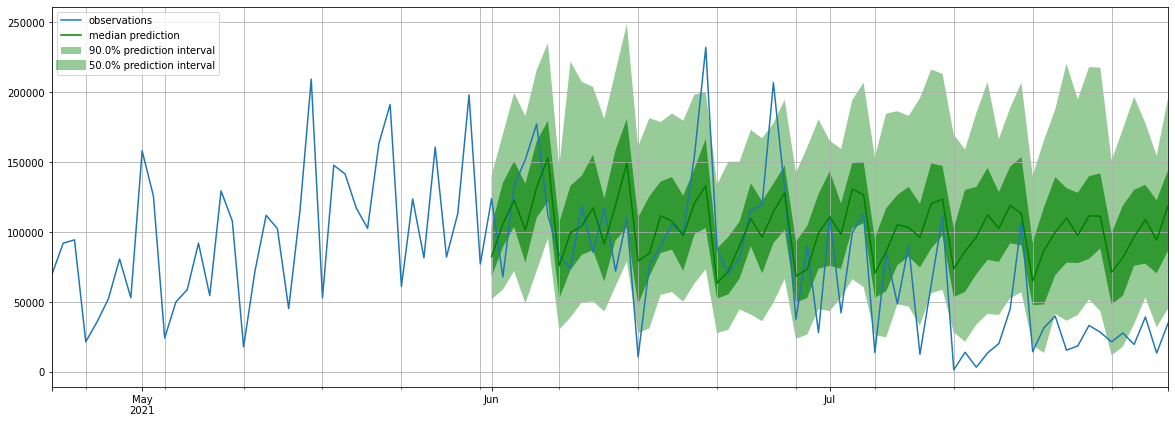

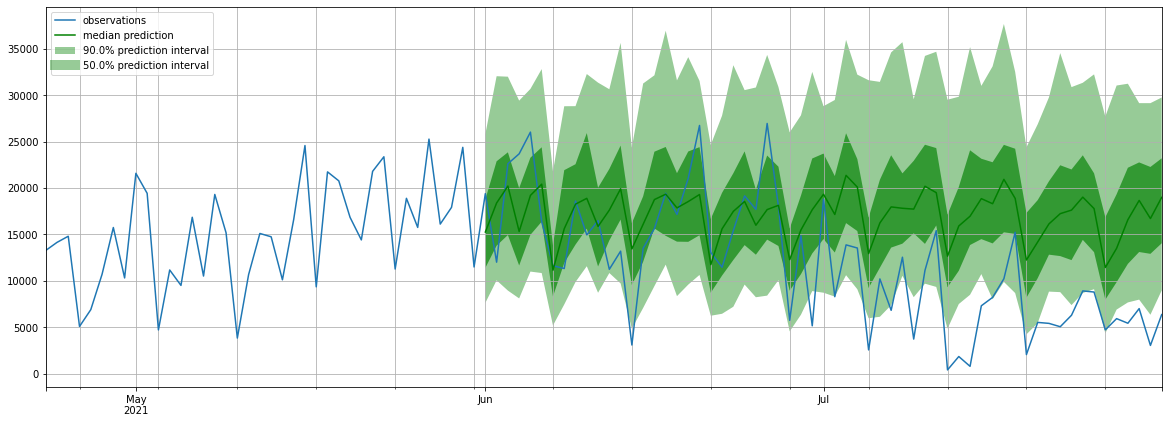

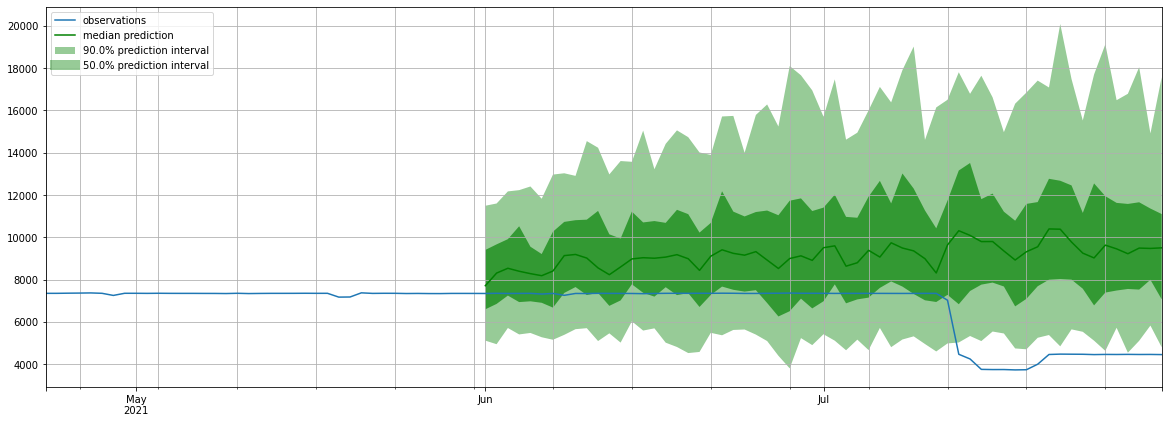

100%|██████████| 90/90 [00:16<00:00,  5.41it/s, epoch=40/40, avg_epoch_loss=6.68]


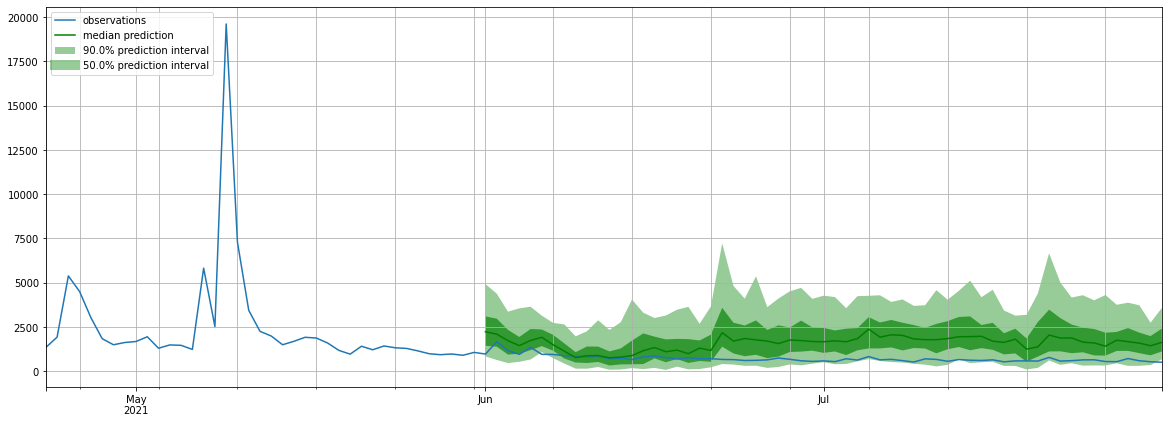

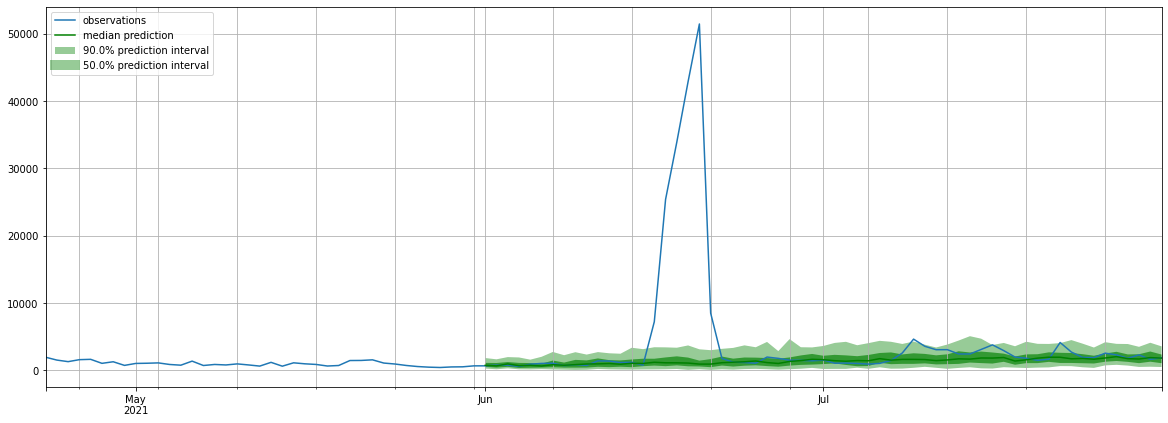

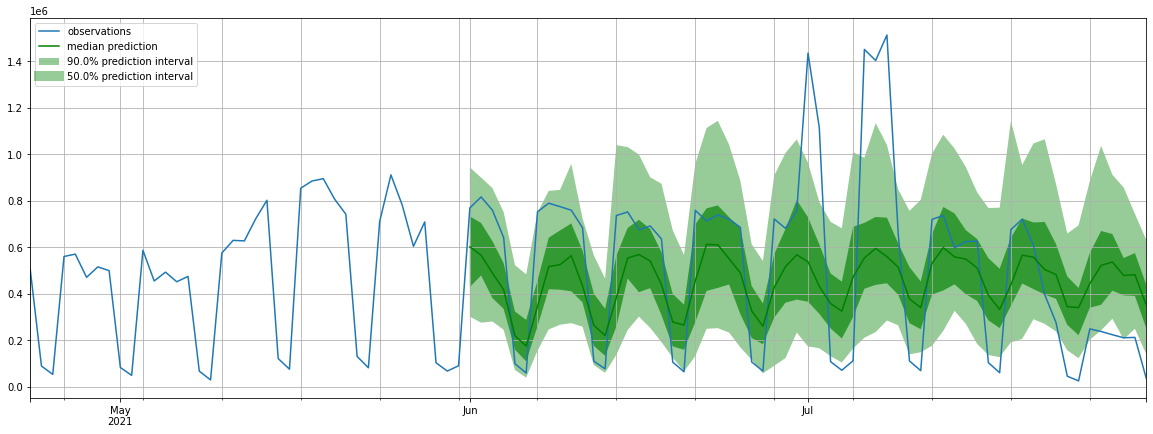

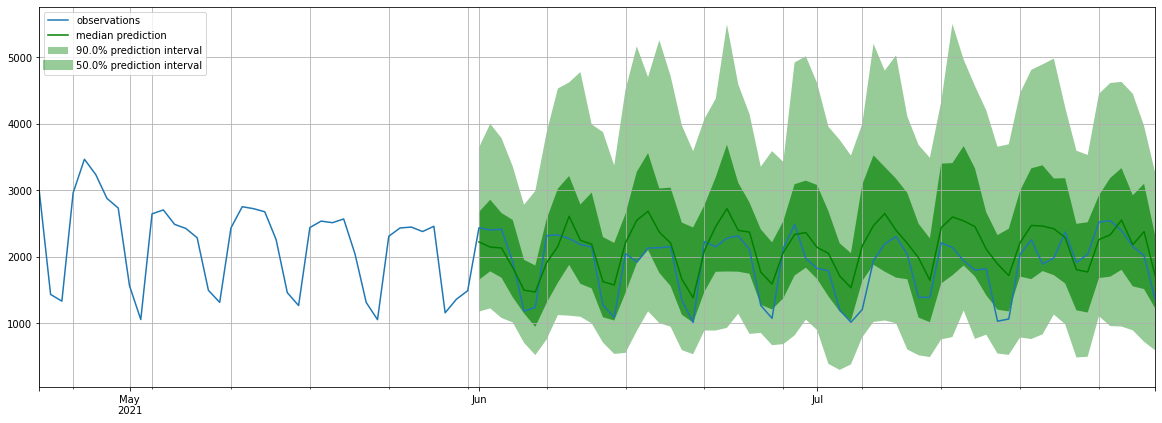

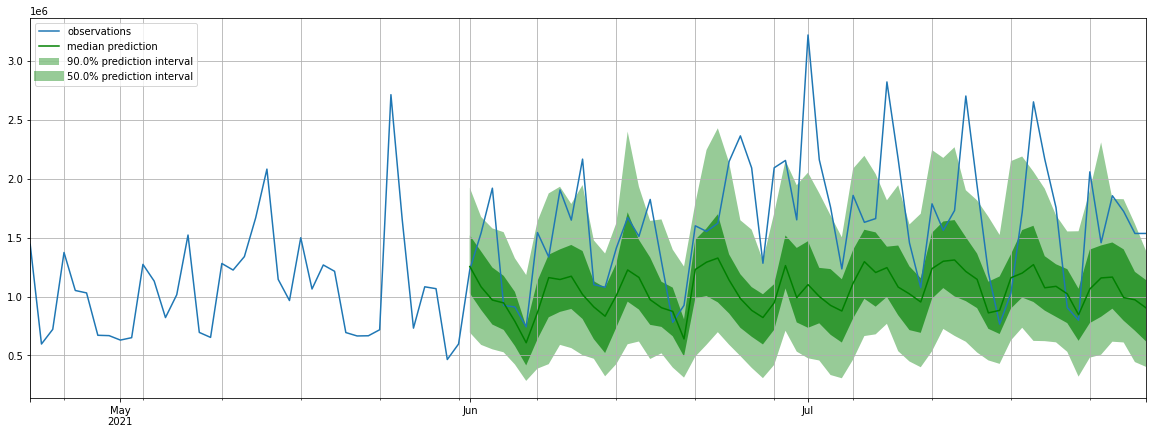

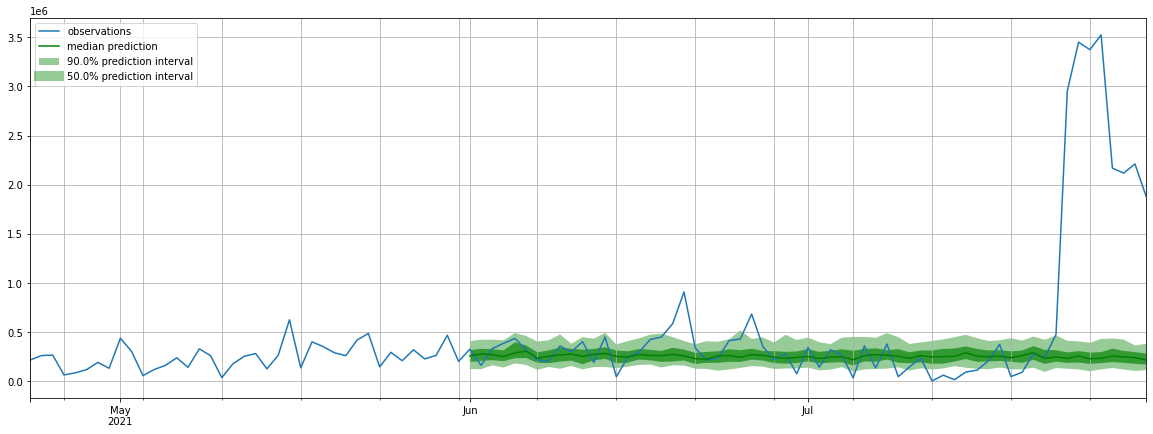

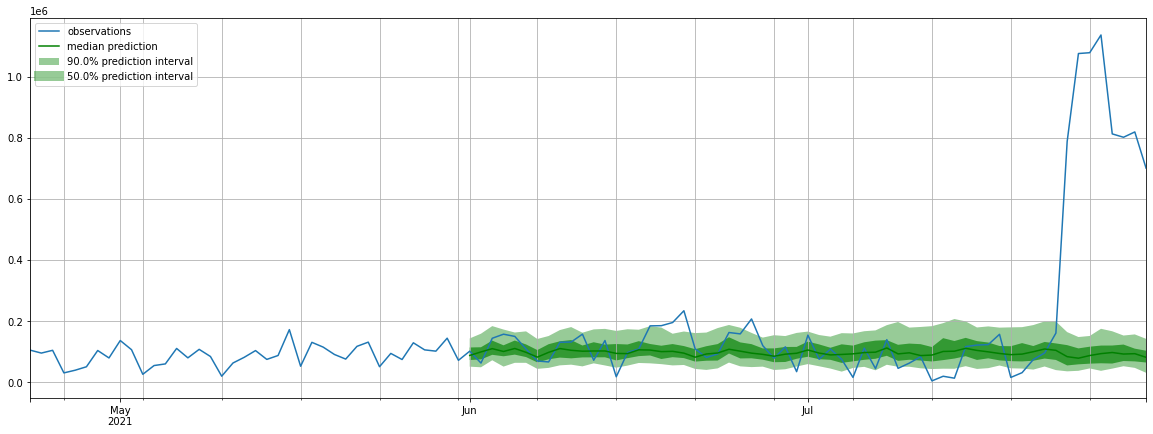

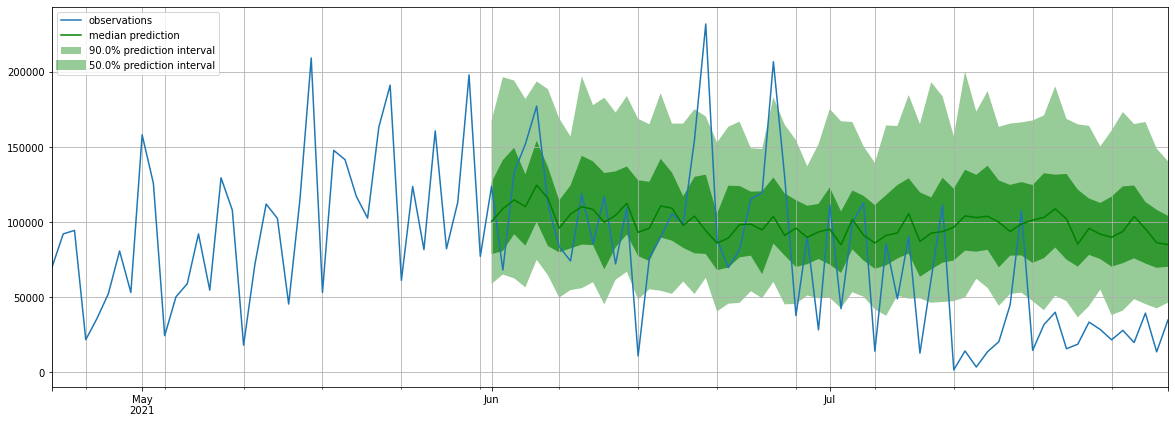

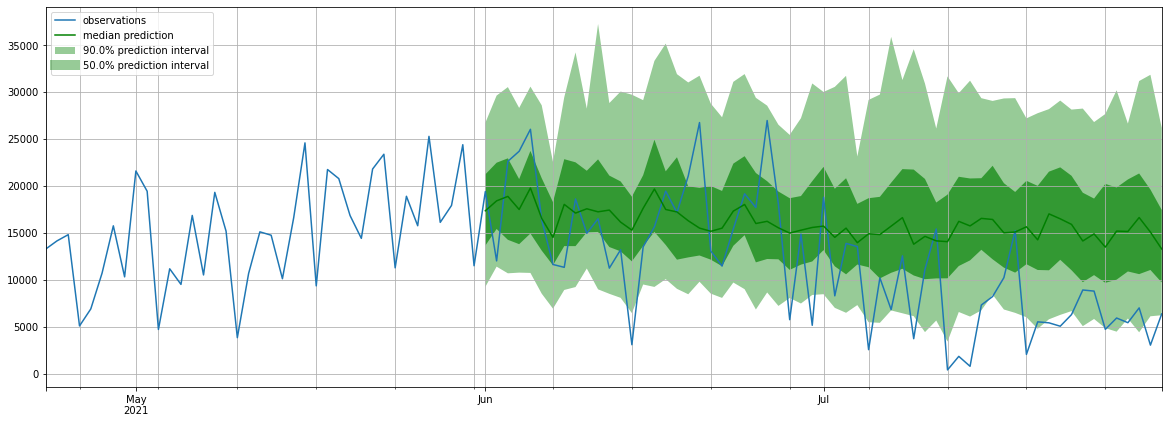

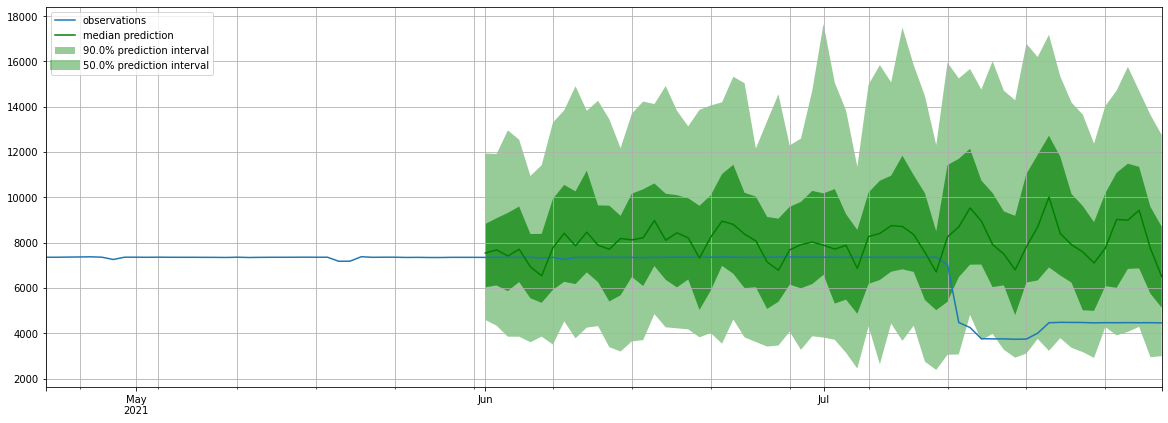

Running evaluation: 100%|██████████| 505/505 [00:00<00:00, 4512.99it/s]


In [21]:
agg_results = []
item_results = []
forecast_results = []
look_back = 1
for lr in [0.01, 0.001, 0.0001]:
    deepAR_estimator = DeepAREstimator(
        prediction_length=ds_meta['prediction_length'],
        context_length=ds_meta['prediction_length']*look_back,
        freq=ds_meta['freq'],
        num_layers=5,
        num_cells=90,
        distr_output = NegativeBinomialOutput(),
        use_feat_dynamic_real=True,
        use_feat_static_cat=False,
    #    cardinality=stat_cat_cardinalities,
        dropout_rate=0.1,
    #    cell_type='lstm',
        trainer=Trainer(   
            ctx=gpu(0),
            learning_rate=lr,
            epochs=40,
            num_batches_per_epoch=90,
            batch_size=32
        )
    )
    deepAR_predictor = deepAR_estimator.train(training_data=train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=deepAR_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    forecast_results.append(forecasts)
    tss = list(ts_it)
    for i in range(10):
        plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    agg_results.append(agg_metrics)
    item_results.append(item_metrics)

### Result review

In [22]:
for a in agg_results:
    print(json.dumps(a, indent=4))
    print('======================================================')

{
    "MSE": 375701261421.6309,
    "abs_error": 2481054159.0,
    "abs_target_sum": 7704185253.0,
    "abs_target_mean": 250095.28495374127,
    "seasonal_error": 28550.678706690196,
    "MASE": 81.08719104607583,
    "MAPE": 19.578805183302066,
    "sMAPE": 0.6401820457834846,
    "MSIS": 3040.5256428021767,
    "QuantileLoss[0.1]": 1070806722.6,
    "Coverage[0.1]": 0.09008277876968024,
    "QuantileLoss[0.5]": 2481054204.0,
    "Coverage[0.5]": 0.44914786560623277,
    "QuantileLoss[0.9]": 1945094630.3999999,
    "Coverage[0.9]": 0.8084401882811232,
    "RMSE": 612944.7458145235,
    "NRMSE": 2.45084486869833,
    "ND": 0.32203978454877896,
    "wQuantileLoss[0.1]": 0.13899026145341317,
    "wQuantileLoss[0.5]": 0.32203979038976,
    "wQuantileLoss[0.9]": 0.2524724635408504,
    "mean_absolute_QuantileLoss": 1832318519.0,
    "mean_wQuantileLoss": 0.2378341717946745,
    "MAE_Coverage": 0.05077638911432128,
    "OWA": NaN
}
{
    "MSE": 691097632751.7773,
    "abs_error": 324191513

In [23]:
mape = []
sids = selected_df['site_id'].to_list()
for f in forecast_results:
    for i in range(ds_meta['num_series']):
        fc_val = f[i].samples
        fc_mean = fc_val.mean(axis=0)
        display_df = nbcu_comp_test[nbcu_comp_test['site_id']==sids[i]].copy()
        display_df['p50'] = fc_mean
        display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
        mape.append(display_df['deviation'].mean())

/tmp/ipykernel_75/1721396326.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
/tmp/ipykernel_75/1721396326.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
/tmp/ipykernel_75/1721396326.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
/tmp/ipykernel_75/1721396326.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
/tmp/ipykernel_75/1721396326.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  display_df

In [28]:
print(mape)

[224.83850227361873, 33.951152718714425, 155.4359085782253, 21.471266271171622, 40.96542889403167, 240.68921560406437, 145.37442047479024, 406.72795441883204, 160.133785230918, 20.058859761776688, 108797.61007155424, inf, 25.525288928418178, inf, 436.8838346166157, inf, 35.299435064161635, 112.4636271945562, 37.25997418106718, 157.80445660836847, 16.17678543059246, 21.66730343443497, 601.2519416908785, inf, inf, 142.1526393907703, 83.45468639780822, 23.729894144517935, 30.697896229694315, 52.66290739160658, 326.8833434711707, 45.046501294191636, 66.27076926689642, inf, 3644.068567470663, inf, 72.90040840750892, inf, inf, 28.936515949605596, 34.31471988255007, 53.06167503042179, 18.26127315832075, inf, inf, inf, 113.24949608615741, inf, 129.19880483135333, 157.82977545934892, 108.05413379437346, 147.3645686464529, inf, 205.77375458666214, 134.52350857424048, 91.19732480440004, 59.763292801757345, 107.8573194998347, 469.15974248926034, inf, 18.22427276488468, inf, inf, 16.88260724672559,

## No Event Training

In [24]:
train_ds2, valid_ds2, test_ds2 = network_dataset(
    merged_df, 
    [],
    freq=ds_meta['freq'],
    valid_length=0, #ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

1790 943 2019-01-01 00:00:00


100%|██████████| 90/90 [00:16<00:00,  5.38it/s, epoch=40/40, avg_epoch_loss=6.47]


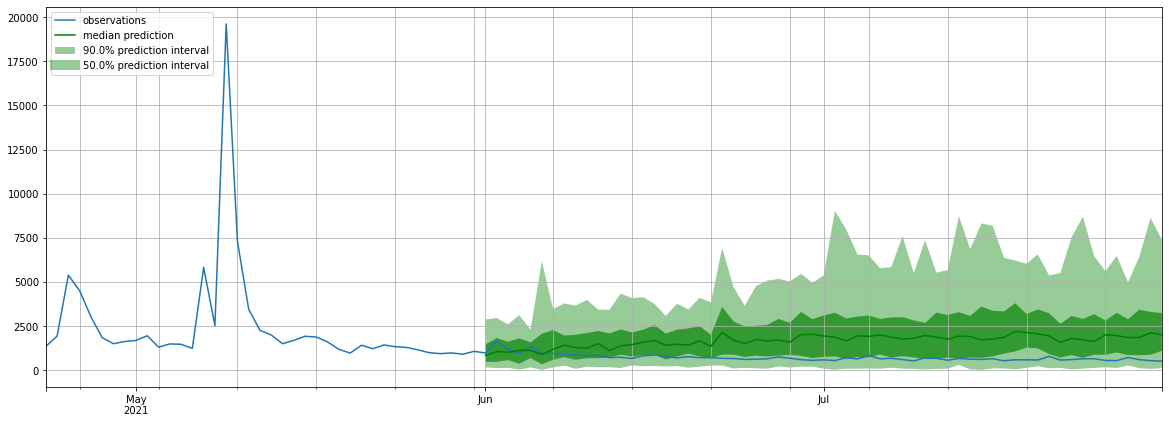

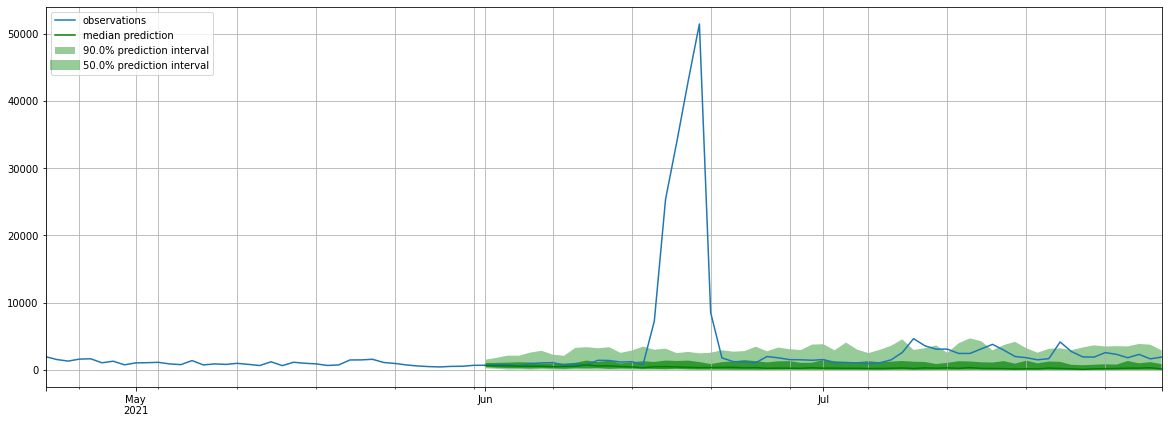

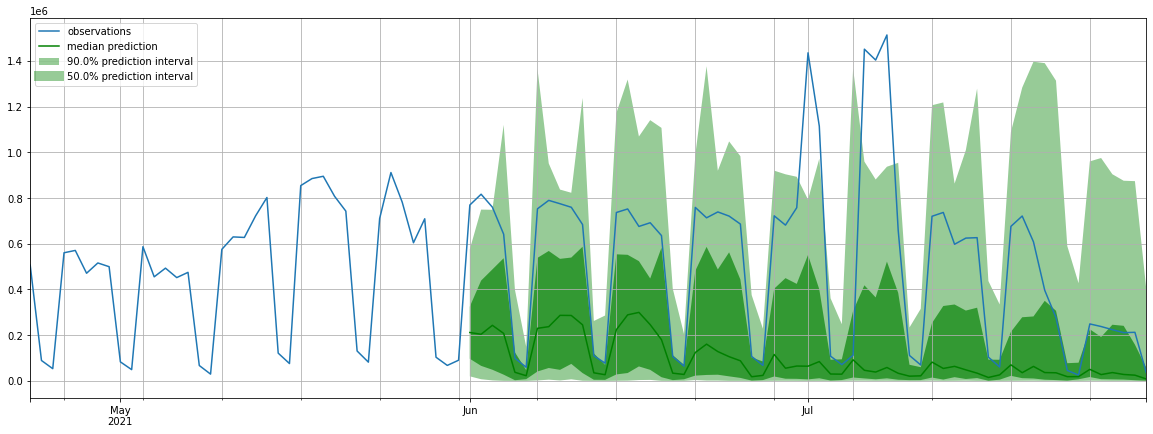

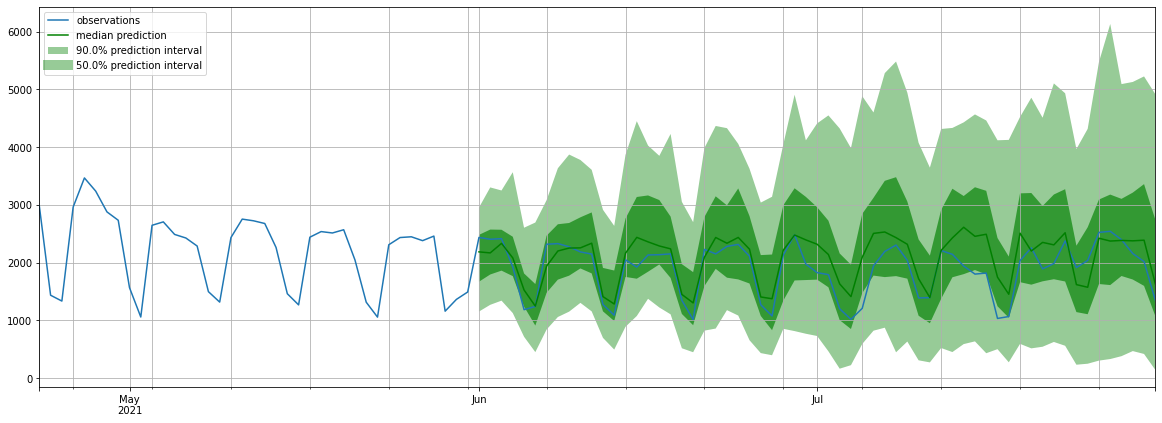

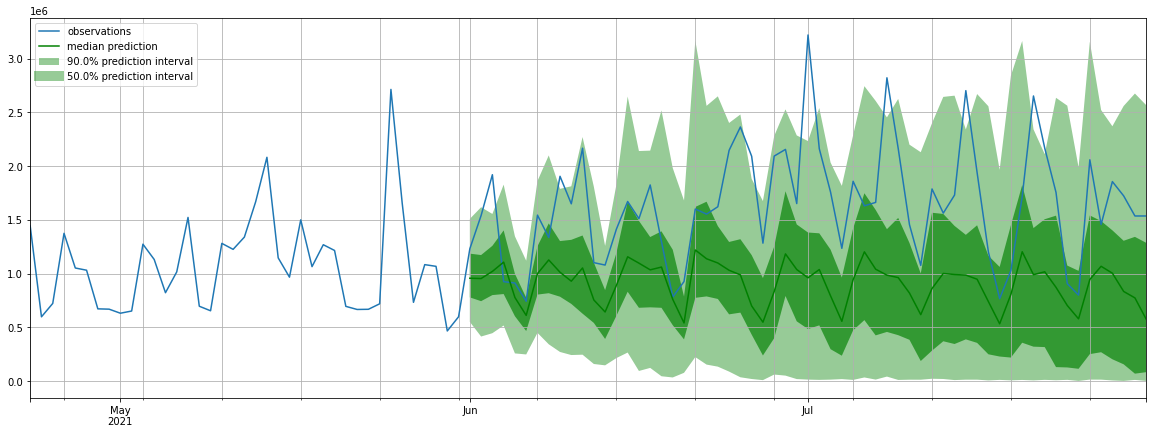

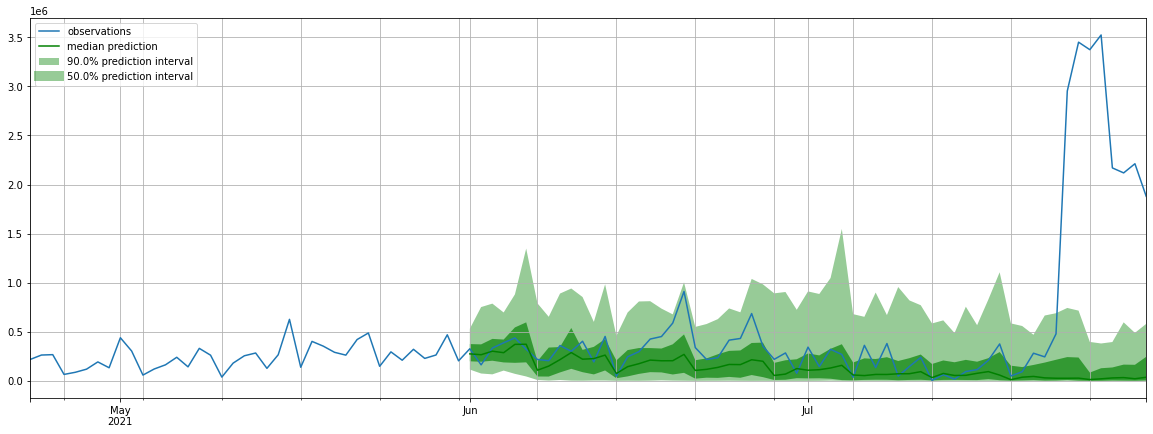

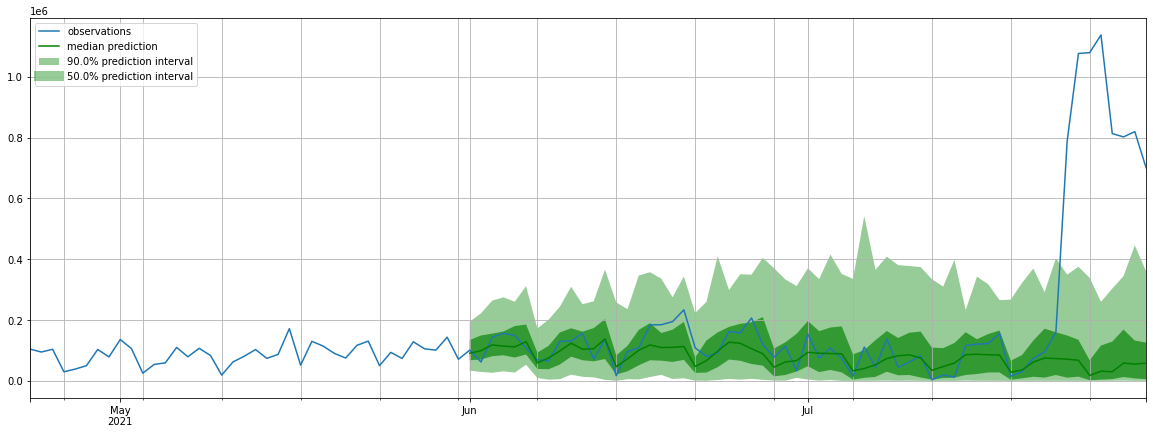

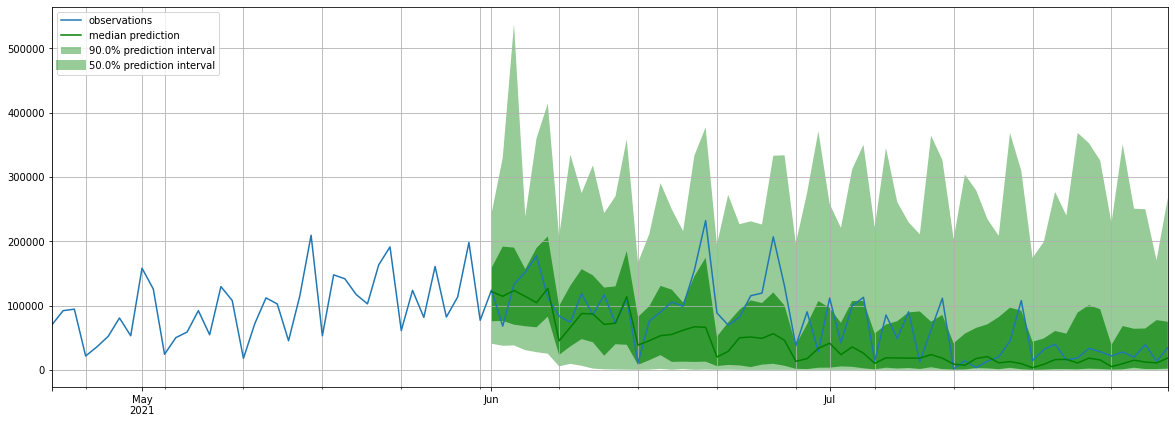

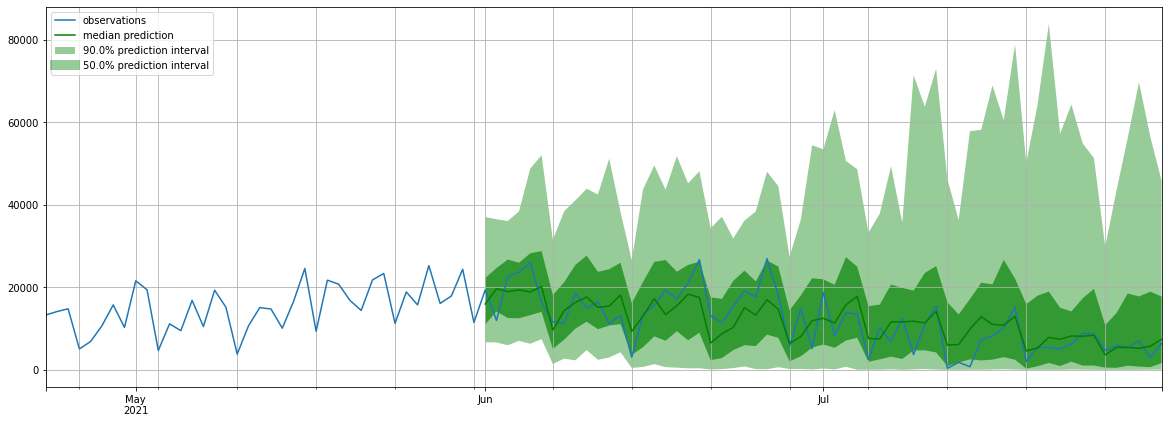

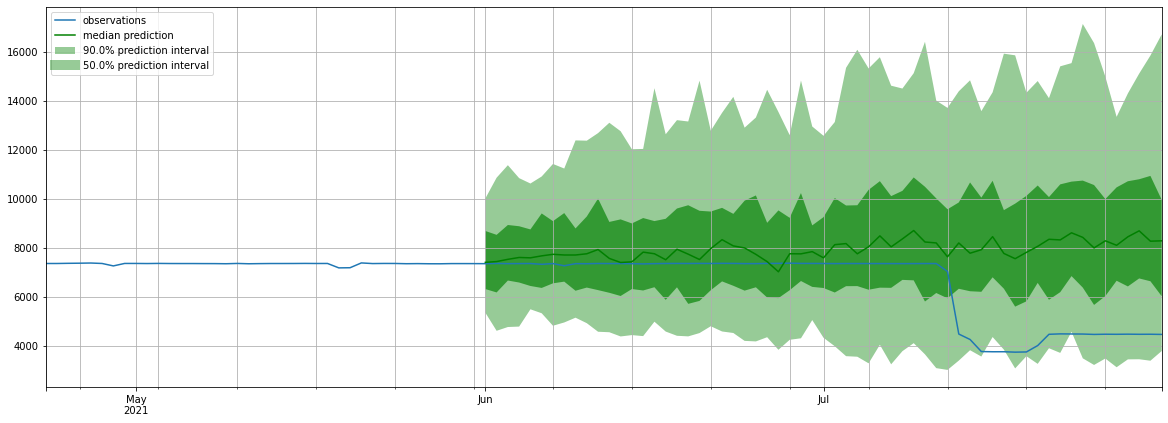

100%|██████████| 90/90 [00:16<00:00,  5.49it/s, epoch=40/40, avg_epoch_loss=6.75]


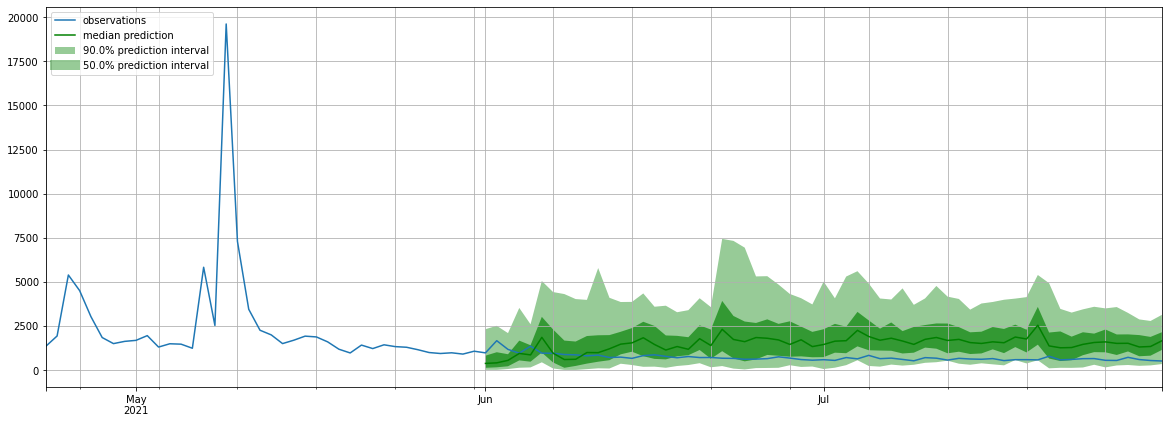

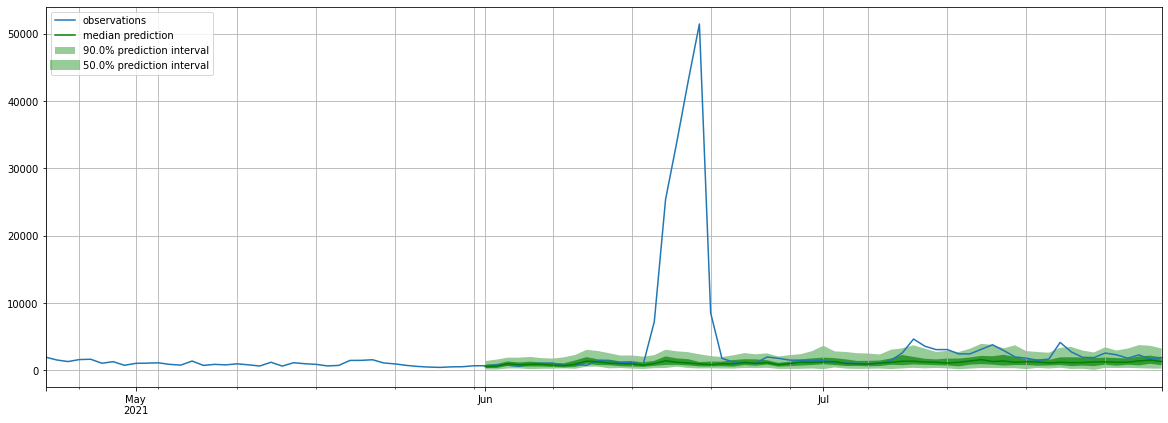

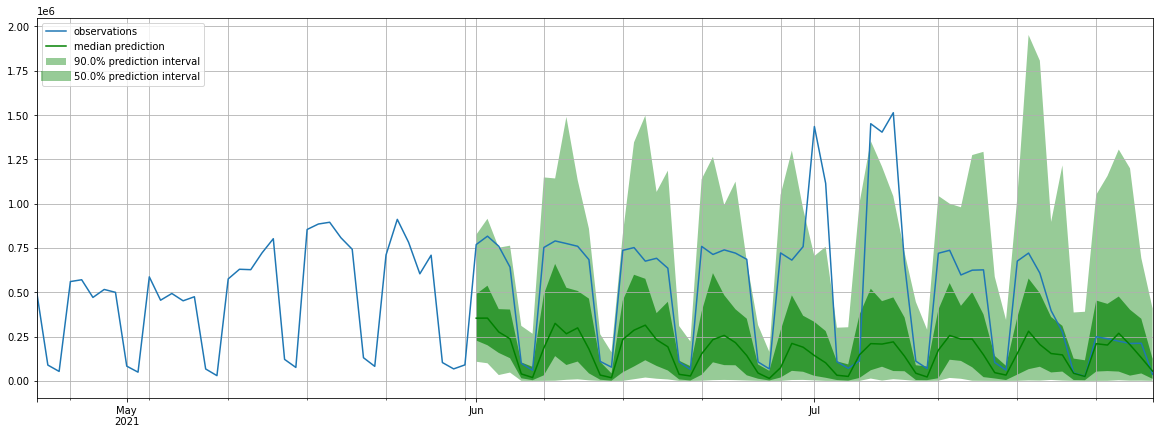

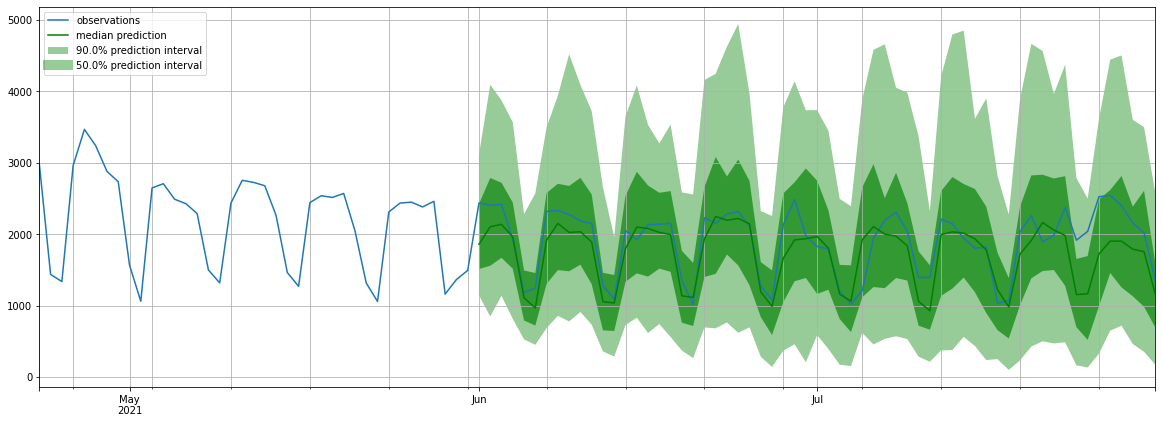

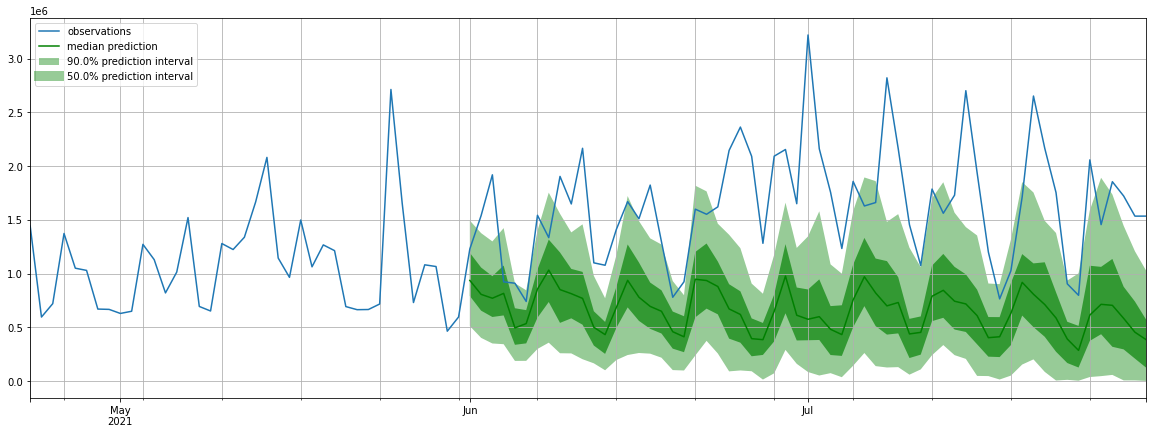

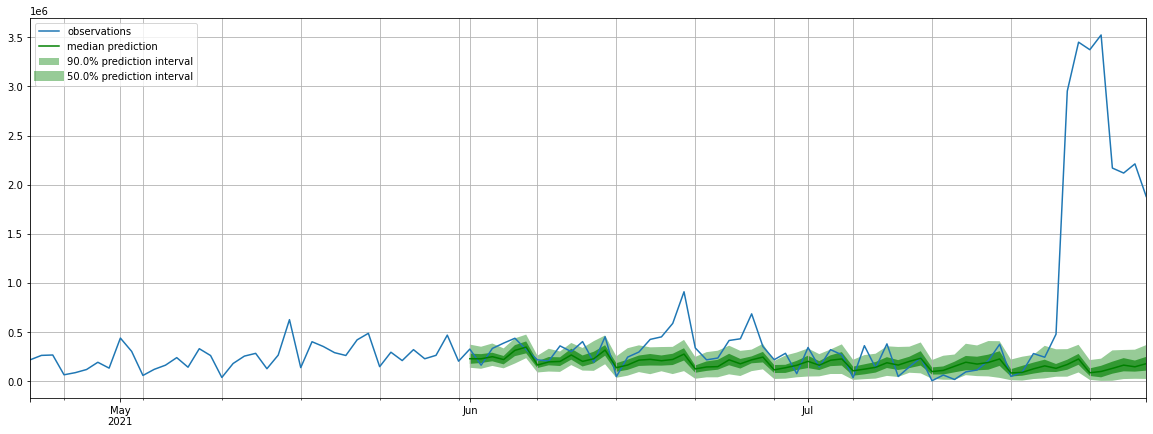

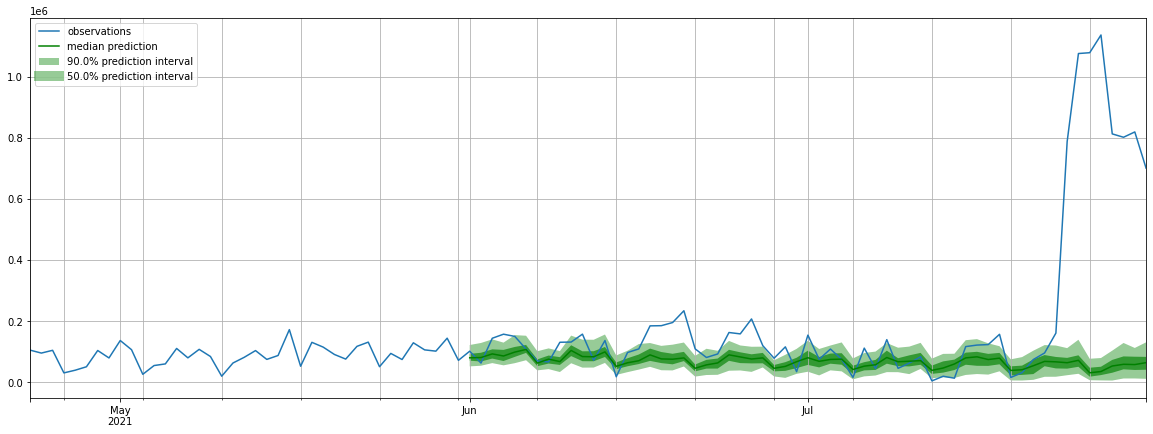

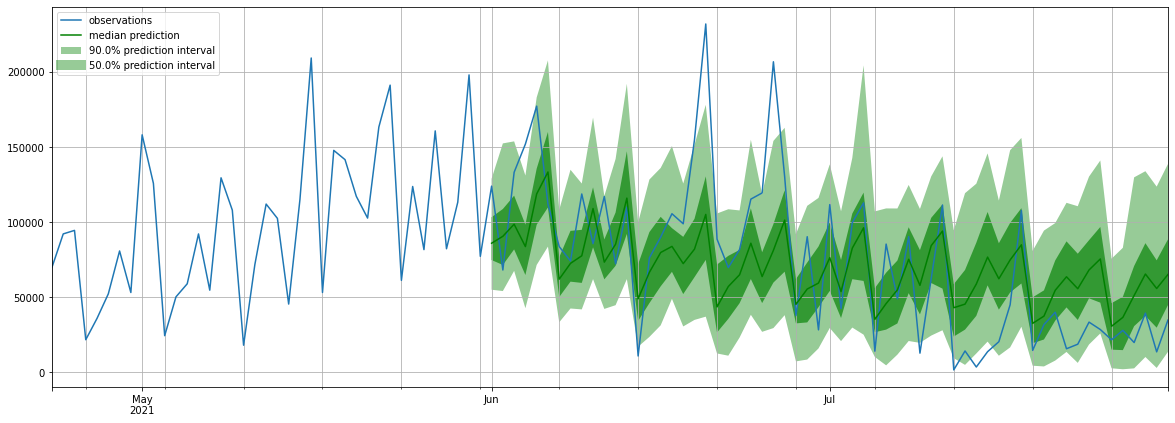

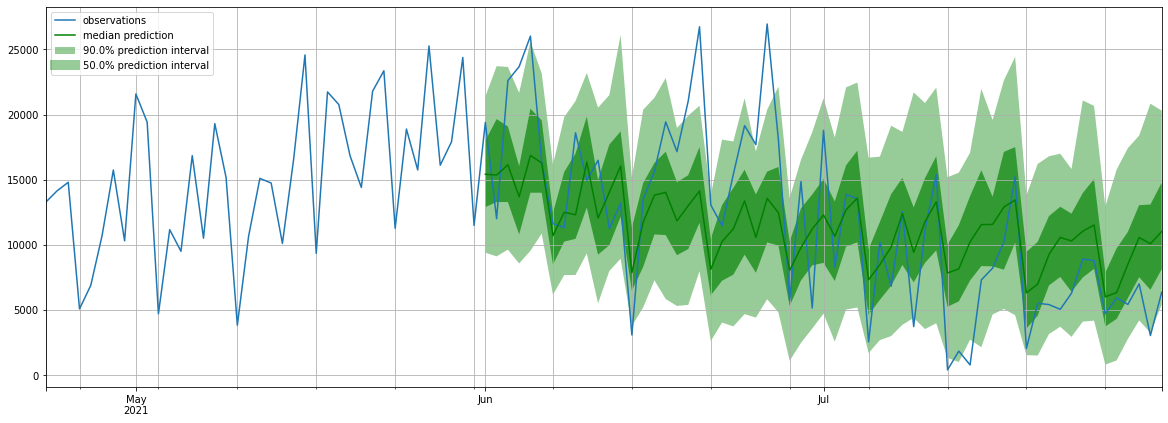

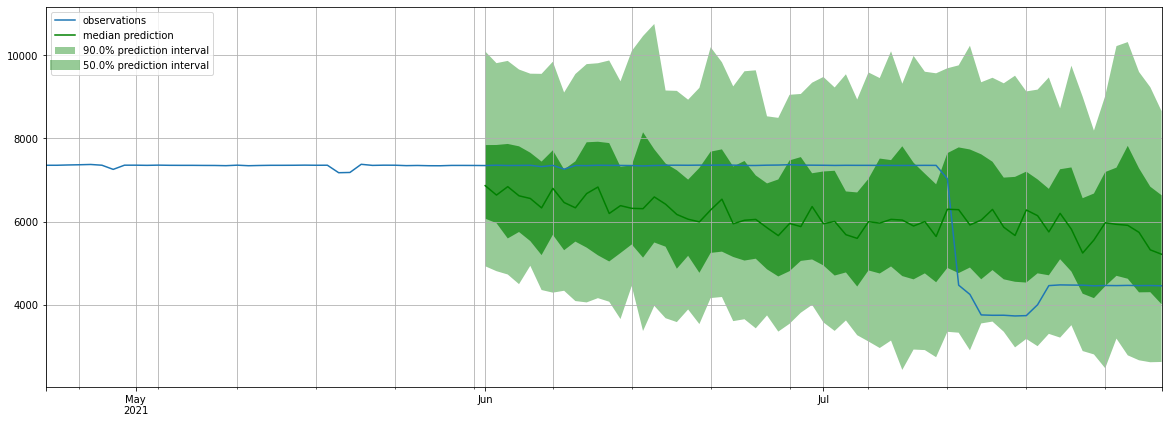

100%|██████████| 90/90 [00:16<00:00,  5.44it/s, epoch=40/40, avg_epoch_loss=7.01]


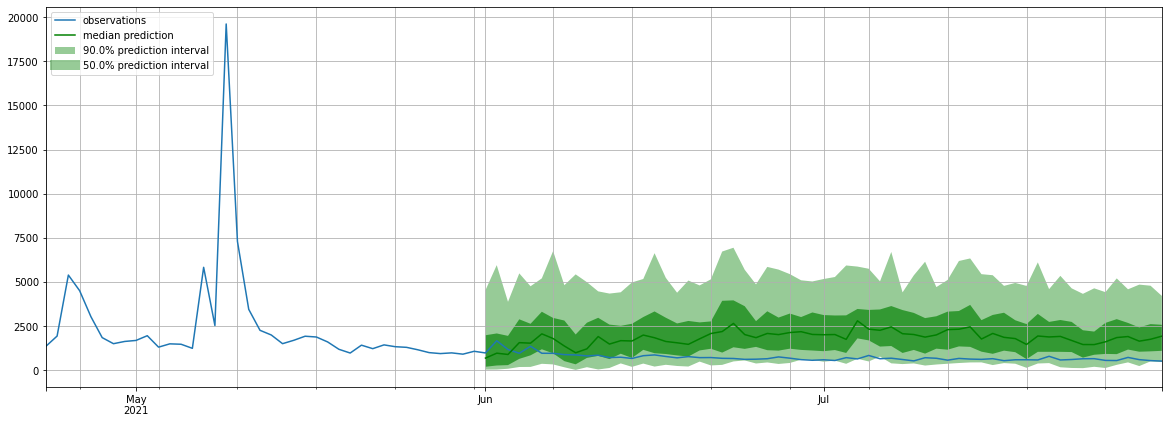

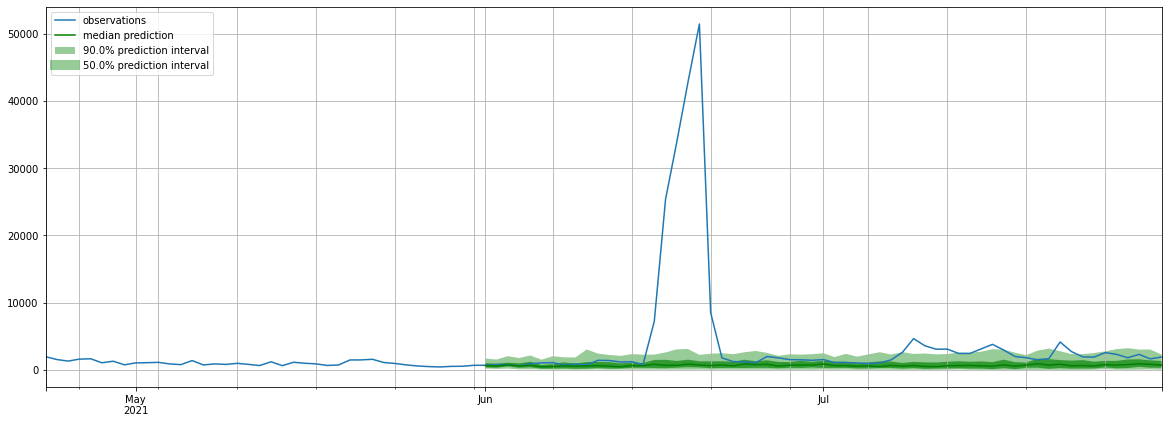

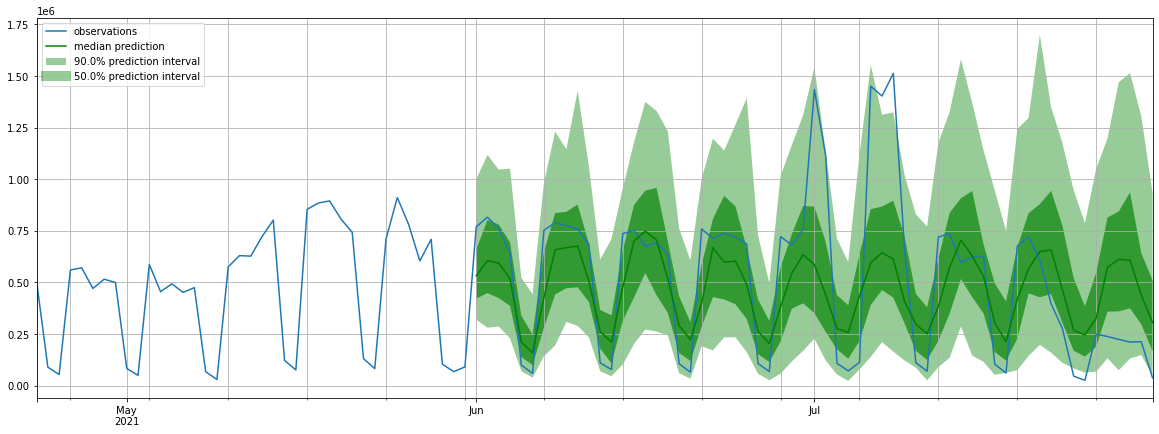

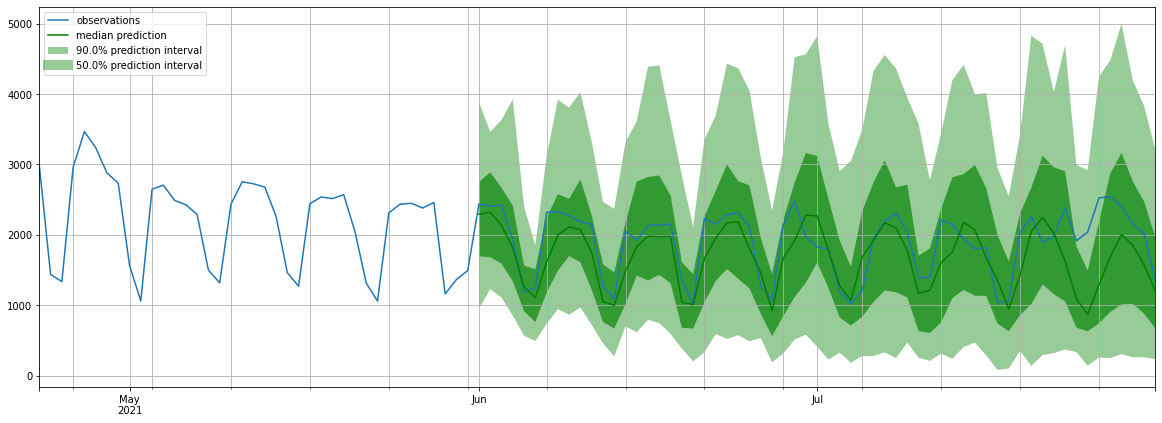

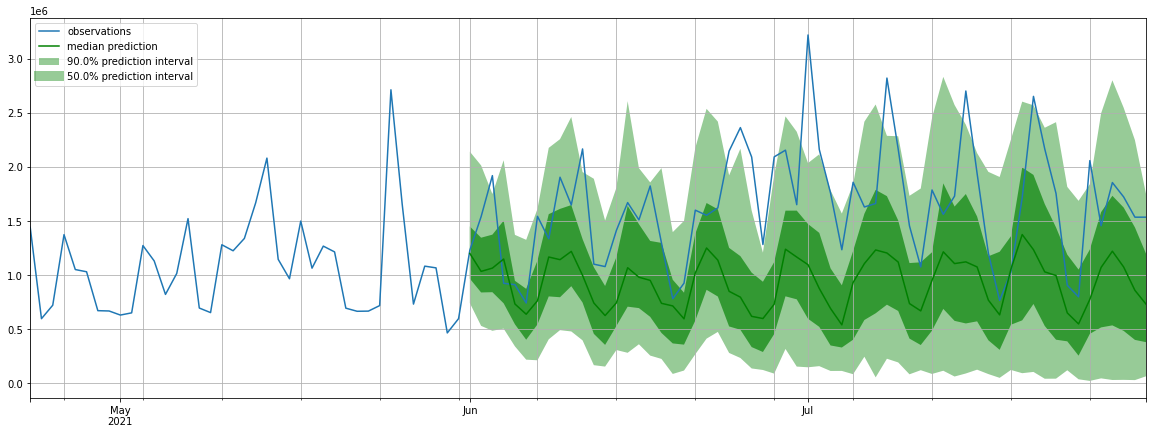

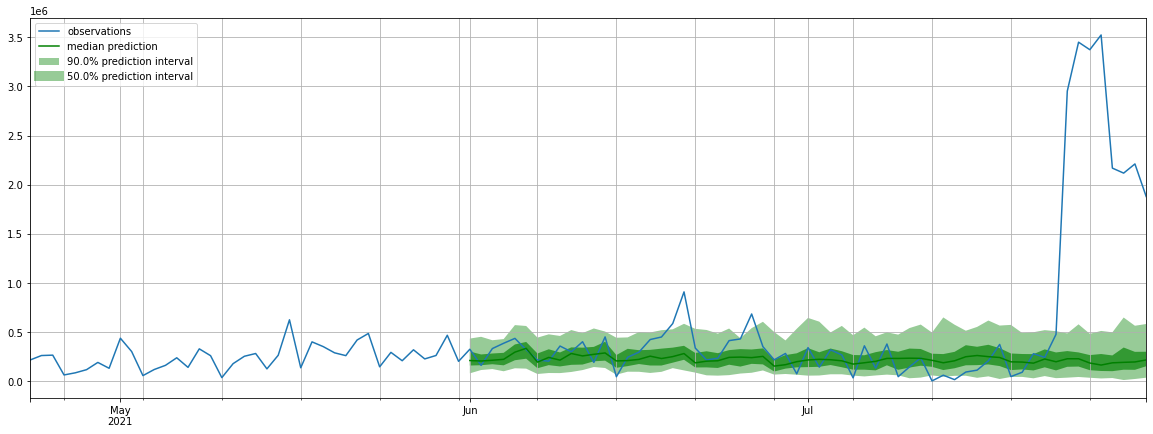

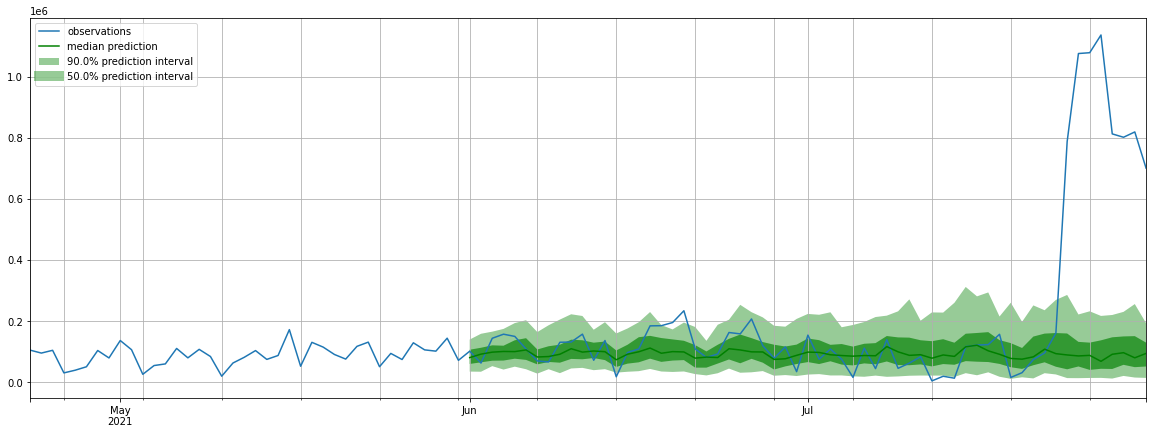

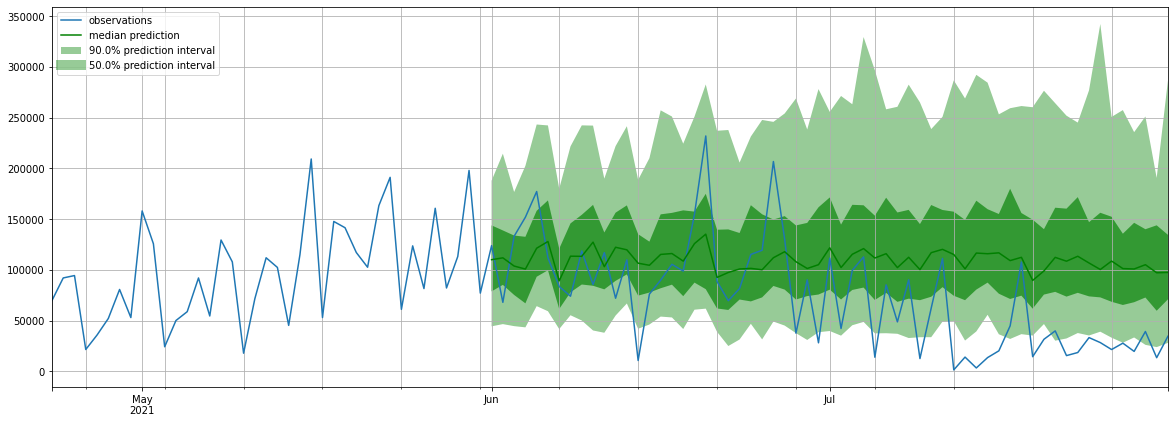

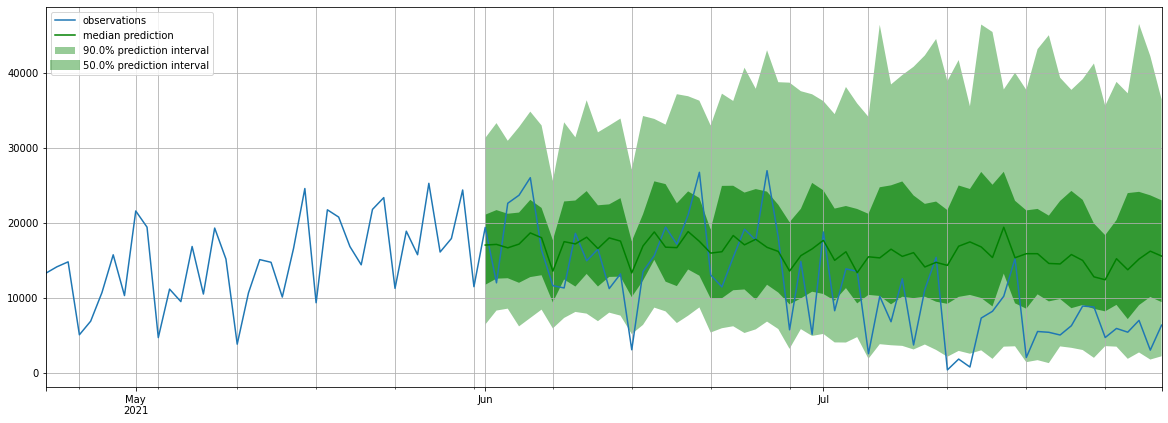

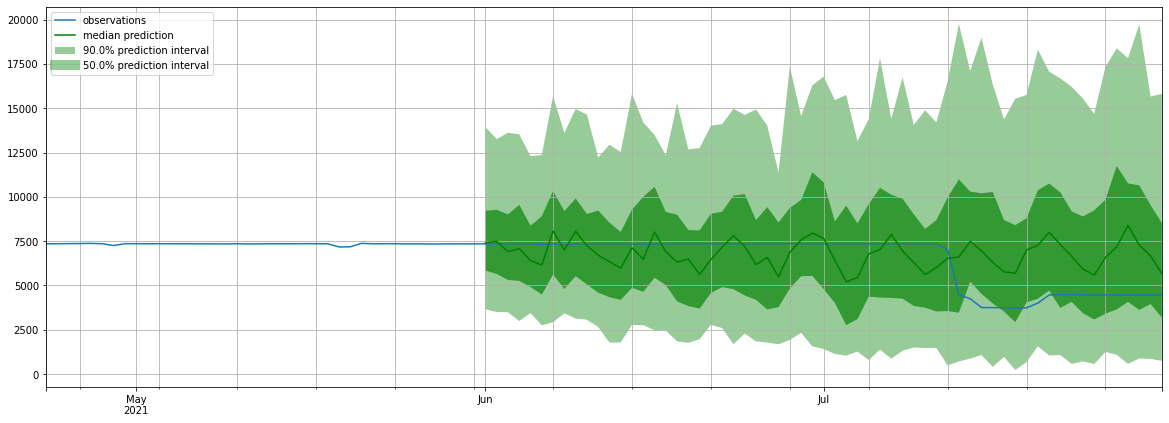

Running evaluation: 100%|██████████| 505/505 [00:00<00:00, 3948.03it/s]


In [25]:
ne_agg_results = []
ne_item_results = []
ne_forecast_results = []
look_back = 1
for lr in [0.01, 0.001, 0.0001]:
    deepAR_estimator = DeepAREstimator(
        prediction_length=ds_meta['prediction_length'],
        context_length=ds_meta['prediction_length']*look_back,
        freq=ds_meta['freq'],
        num_layers=5,
        num_cells=90,
        distr_output = NegativeBinomialOutput(),
        use_feat_dynamic_real=False,
        use_feat_static_cat=False,
    #    cardinality=stat_cat_cardinalities,
        dropout_rate=0.1,
    #    cell_type='lstm',
        trainer=Trainer(   
            ctx=gpu(0),
            learning_rate=lr,
            epochs=40,
            num_batches_per_epoch=90,
            batch_size=32
        )
    )
    deepAR_predictor = deepAR_estimator.train(training_data=train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=deepAR_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    ne_forecast_results.append(forecasts)
    tss = list(ts_it)
    for i in range(10):
        plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    ne_agg_results.append(agg_metrics)
    ne_item_results.append(item_metrics)

### Review result

In [27]:
for a in ne_agg_results:
    print(json.dumps(a, indent=4))
    print('======================================================')

{
    "MSE": 419206217731.5466,
    "abs_error": 2617353365.0,
    "abs_target_sum": 7704185253.0,
    "abs_target_mean": 250095.28495374127,
    "seasonal_error": 28550.678706690196,
    "MASE": 81.12049313910089,
    "MAPE": 9.318889728977505,
    "sMAPE": 0.6416695020829406,
    "MSIS": 3057.6470765417816,
    "QuantileLoss[0.1]": 992112146.4,
    "Coverage[0.1]": 0.04966726180814803,
    "QuantileLoss[0.5]": 2617353313.0,
    "Coverage[0.5]": 0.49728940107125463,
    "QuantileLoss[0.9]": 1963009017.3999996,
    "Coverage[0.9]": 0.9016718065249149,
    "RMSE": 647461.3638909635,
    "NRMSE": 2.5888587384233204,
    "ND": 0.3397313640635531,
    "wQuantileLoss[0.1]": 0.12877573861735384,
    "wQuantileLoss[0.5]": 0.339731357313975,
    "wQuantileLoss[0.9]": 0.2547977434259653,
    "mean_absolute_QuantileLoss": 1857491492.2666664,
    "mean_wQuantileLoss": 0.24110161311909806,
    "MAE_Coverage": 0.018238381215170723,
    "OWA": NaN
}
{
    "MSE": 536360927443.9682,
    "abs_error": 2

In [ ]:
ne_mape = []
sids = selected_df['site_id'].to_list()
for f in forecast_results:
    for i in range(ds_meta['num_series']):
        fc_val = f[i].samples
        fc_mean = fc_val.mean(axis=0)
        display_df = nbcu_comp_test[nbcu_comp_test['site_id']==sids[i]].copy()
        display_df['p50'] = fc_mean
        display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
        ne_mape.append(display_df['deviation'].mean())

In [ ]:
print(ne_mape)